# Importing Modules

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.style as style
import matplotlib.pyplot as plt 
# from google.colab import files
import tensorflow as tf

style.use('seaborn-dark')
print(tf.__version__)

2.4.1


In [2]:
# upload_df = files.upload()

In [3]:
df = pd.read_csv('Sunspots.csv')
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [4]:
time = np.array(df['Unnamed: 0'])
series = np.array(df['Monthly Mean Total Sunspot Number'])

In [5]:
def plot_series(time , series , start = 0 , end = None , text = None):
    plt.plot(time[start : end] , series[start : end] , label = text)
    if text:
        if text is list:
            plt.legend(text)
        else:
            plt.legend([text])
    plt.ylabel('Sunspot Value')
    plt.xlabel('Time')
    plt.title('Sunspot Time Series')

def split_dataset(series , time , split_val):
    time_train = time[:split_val]
    series_train = series[:split_val]
    time_val = time[split_val : ]
    series_val = series[split_val : ]
    return (time_train , series_train , time_val , series_val)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
time_train , series_train , time_val , series_val  = split_dataset(series , time , 2500)
print(len(time))

3252


In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000
train_set = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(series_train.shape)


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [8]:
tf.keras.backend.clear_session()

tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 64
train_set = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(series_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  # tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
39/39 [==============================] - 5s 49ms/step - loss: 161.1540 - mae: 161.6540
Epoch 2/100
39/39 [==============================] - 2s 50ms/step - loss: 87.9417 - mae: 88.4405
Epoch 3/100
39/39 [==============================] - 2s 51ms/step - loss: 53.7587 - mae: 54.2565
Epoch 4/100
39/39 [==============================] - 2s 51ms/step - loss: 50.1614 - mae: 50.6592
Epoch 5/100
39/39 [==============================] - 2s 51ms/step - loss: 47.9993 - mae: 48.4971
Epoch 6/100
39/39 [==============================] - 2s 50ms/step - loss: 48.2613 - mae: 48.7590
Epoch 7/100
39/39 [==============================] - 2s 51ms/step - loss: 47.0161 - mae: 47.5139
Epoch 8/100
39/39 [==============================] - 2s 51ms/step - loss: 46.2476 - mae: 46.7454
Epoch 9/100
39/39 [==============================] - 2s 48ms/step - loss: 45.5270 - mae: 46.0249
Epoch 10/100
39/39 [===

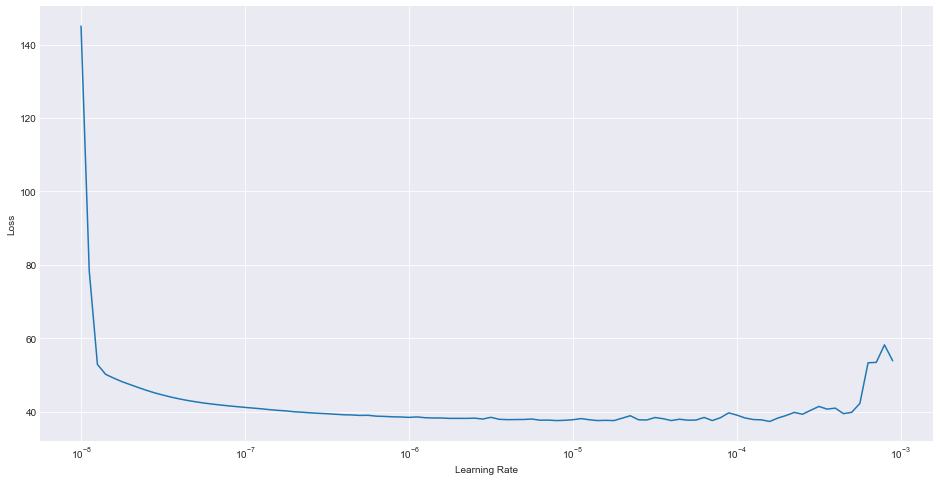

In [9]:
plt.figure(figsize = (16,8))
plt.semilogx(history.history['lr'] , history.history['mae'])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [10]:
loss_x = 10000
lr_x = 10000
for lr , loss in zip(history.history['lr'] , history.history['mae']):
  if loss<loss_x:
    lr_x = lr
    loss_x = loss
print(loss_x , lr_x)

37.349361419677734 0.00015848932


In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

import os 

root_logdir = os.path.join(os.curdir , "my_logs")

def get_run_logdir():
  import time
  run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
  return os.path.join(root_logdir , run_id)

run_logdir = get_run_logdir()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500 , callbacks = [tensorboard_cb])

9
Epoch 299/500
39/39 [==============================] - 2s 42ms/step - loss: 15.2076 - mae: 15.6967
Epoch 300/500
39/39 [==============================] - 2s 42ms/step - loss: 15.0098 - mae: 15.4977
Epoch 301/500
39/39 [==============================] - 2s 42ms/step - loss: 14.9805 - mae: 15.4676
Epoch 302/500
39/39 [==============================] - 2s 42ms/step - loss: 14.7075 - mae: 15.1940
Epoch 303/500
39/39 [==============================] - 2s 42ms/step - loss: 14.8043 - mae: 15.2909
Epoch 304/500
39/39 [==============================] - 2s 42ms/step - loss: 14.6994 - mae: 15.1856
Epoch 305/500
39/39 [==============================] - 2s 43ms/step - loss: 15.0097 - mae: 15.4976
Epoch 306/500
39/39 [==============================] - 2s 42ms/step - loss: 14.8493 - mae: 15.3362
Epoch 307/500
39/39 [==============================] - 2s 42ms/step - loss: 14.5979 - mae: 15.0841
Epoch 308/500
39/39 [==============================] - 2s 42ms/step - loss: 14.7654 - mae: 15.2527
Epoch 30

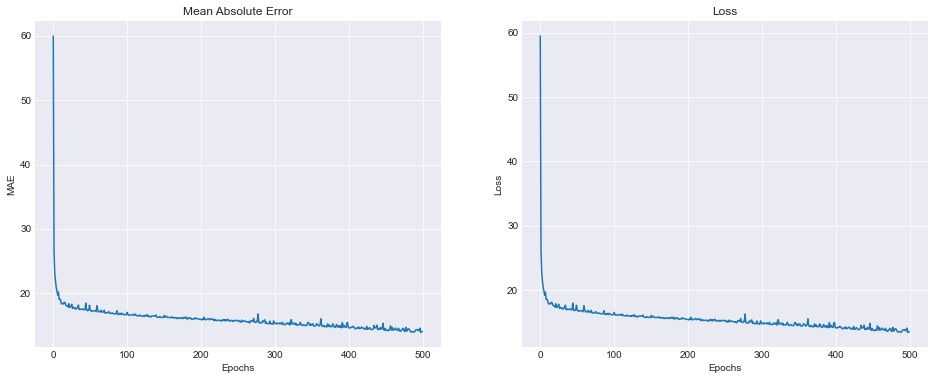

In [12]:
mae = history.history['mae']
loss = history.history['loss']
epochs = range(len(mae))

fig , ax = plt.subplots(1,2)
fig.set_size_inches(16,6)
ax[0].grid()
ax[1].grid()
ax[0].plot(epochs , mae)
ax[1].plot(epochs , loss)
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('MAE')
ax[1].set_ylabel('Loss')
ax[0].set_title('Mean Absolute Error')
ax[1].set_title('Loss')
import matplotlib 
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 

In [13]:
def model_forecast(model, series, window_size):
    series = np.expand_dims(series , axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [16]:
predict = model_forecast(model , series , window_size)[2500 - window_size:-1, -1, 0]

In [17]:
print(predict.shape)

(752,)


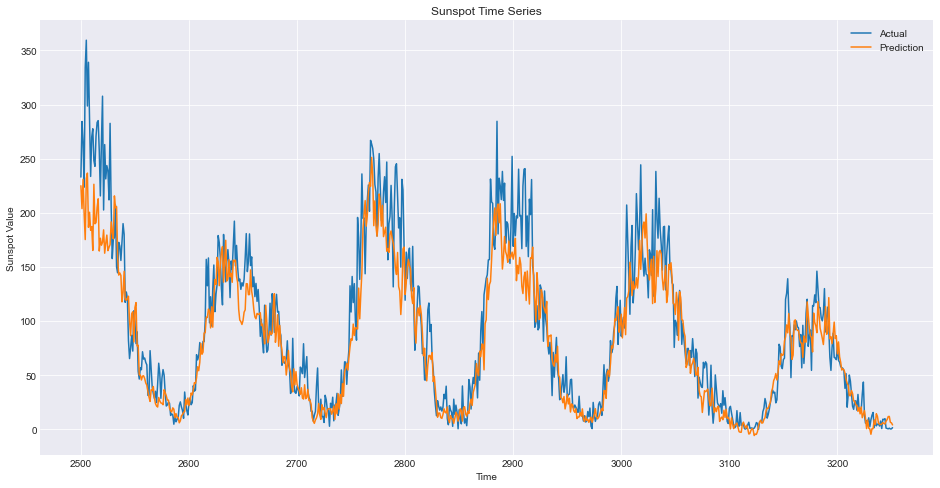

In [18]:
plt.figure(figsize = (16,8))
plot_series(time_val , series_val)
plot_series(time_val , predict)
plt.legend(['Actual' , 'Prediction'])
plt.grid(True)
plt.show()

In [19]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 13948.